<a href="https://colab.research.google.com/github/rohinidat/2-CHL5230-F23/blob/main/Rohini_Datta_RNN_Datathon_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Import

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from tqdm import tqdm
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings('ignore')

In [3]:
#Import dataset
from google.colab import files
uploaded = files.upload()

Saving mhealth.csv to mhealth.csv


In [4]:
#Upload dataset
mhealth_data = pd.read_csv('mhealth.csv')

In [5]:
#Display data
mhealth_data.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


#Data Exploration

In [6]:
#Explore dataset
description = mhealth_data.describe()
description

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity
count,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
mean,1.473954,-9.618162,-0.944714,-0.023928,-0.616830,-0.131466,-3.578801,-5.72591,2.645165,-0.293943,-0.450610,0.283440,1.702181
std,3.751845,4.076683,5.333969,0.495758,0.354135,0.547774,4.770602,5.70559,3.897641,0.528506,0.564118,0.558707,3.250841
min,-22.146000,-19.619000,-19.373000,-2.146600,-7.789900,-2.567800,-22.361000,-18.97200,-18.239000,-8.339200,-3.570800,-2.689700,0.000000
25%,0.115100,-10.116000,-2.662400,-0.454550,-0.816140,-0.561890,-5.984100,-9.36790,0.406120,-0.711760,-0.882960,-0.211210,0.000000
50%,1.336800,-9.644800,-0.016372,-0.070501,-0.703560,-0.137520,-2.859700,-7.35990,2.231200,-0.372550,-0.622180,0.325430,0.000000
75%,2.586900,-9.034300,1.371500,0.426720,-0.542210,0.345780,-1.021200,-2.45280,5.201200,0.049020,-0.080082,0.786640,2.000000
max,20.054000,21.161000,25.015000,60.484000,2.011300,2.770100,19.864000,22.19100,25.741000,3.319600,1.556500,2.750000,12.000000


In [7]:
#Group by subject ID (verify each subject has at least 2 records)

#First obtain subjects with at least 2 records
patients_records = (mhealth_data.groupby('subject').apply(len) >= 2)

#Filter datset to obtain subjects with at least 2 records
patients_records_df = mhealth_data[mhealth_data['subject'].isin(patients_records[patients_records].index)] #All subject had at least 2 records

In [8]:
#Update dataset
mhealth_data = patients_records_df

In [9]:
# Checking for missing values
print(mhealth_data.isnull().sum())

alx         0
aly         0
alz         0
glx         0
gly         0
glz         0
arx         0
ary         0
arz         0
grx         0
gry         0
grz         0
Activity    0
subject     0
dtype: int64


In [10]:
#Data shape
print(mhealth_data.shape)

(999999, 14)


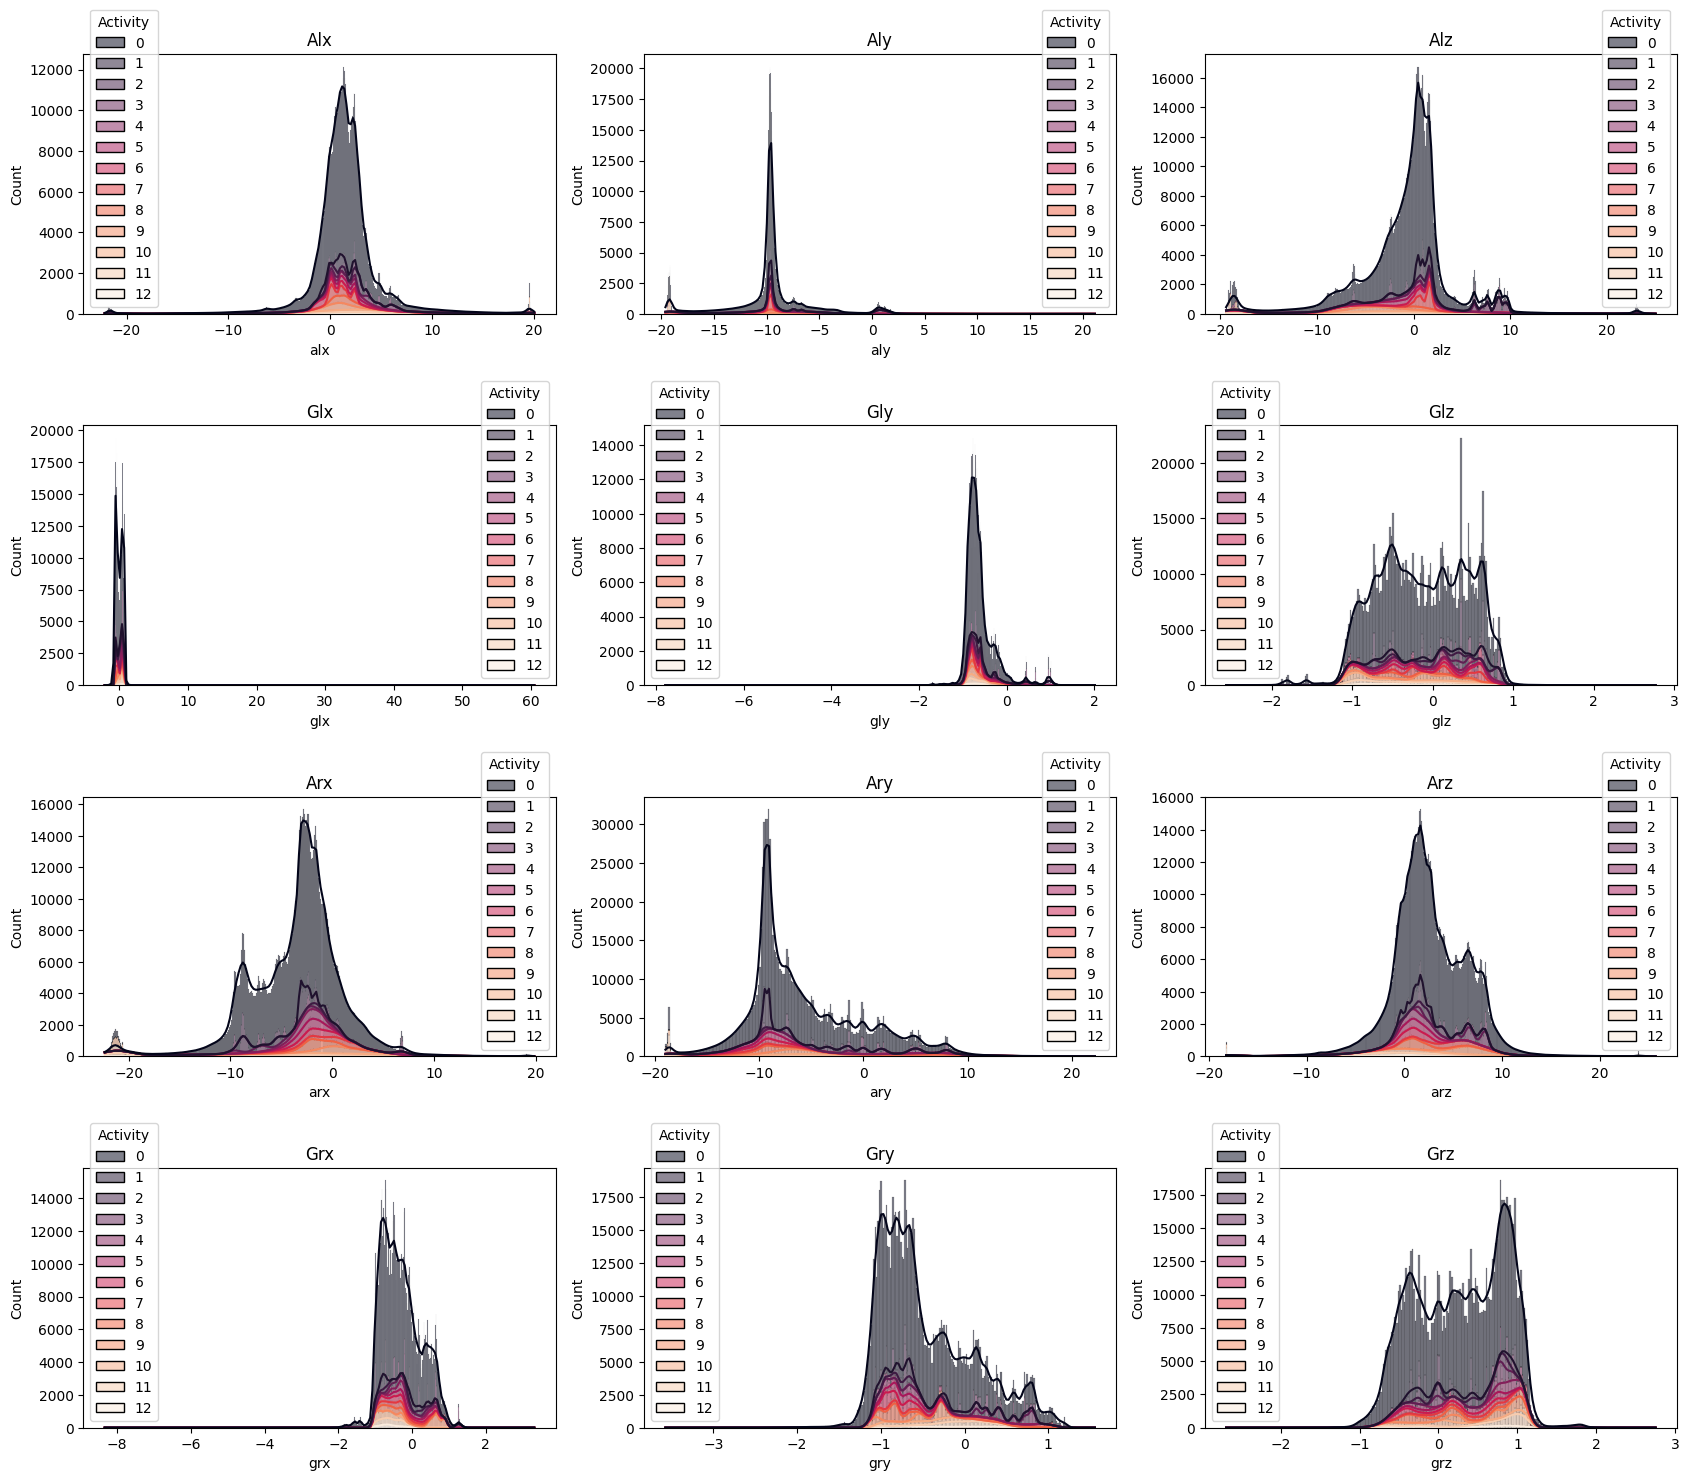

In [ ]:
#Sensor-related features
columns = ['alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'arx', 'ary', 'arz', 'grx', 'gry', 'grz']

#Create a grid of subplots with 3 rows and 3 columns
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(17, 15))

#Loop over each selected feature to create a subplot for each
for i, column in enumerate(columns):
    x = i // 3
    y = i % 3

    #Plot a histogram of the feature split by the 'Activity' class
    sns.histplot(mhealth_data, x=column, hue='Activity', kde=True, palette='rocket', ax=axs[x][y],
                 multiple='stack')
    axs[x][y].set_title(column.replace('_', ' ').title())

#Adjust the layout and display all the subplots
plt.tight_layout()
plt.show()

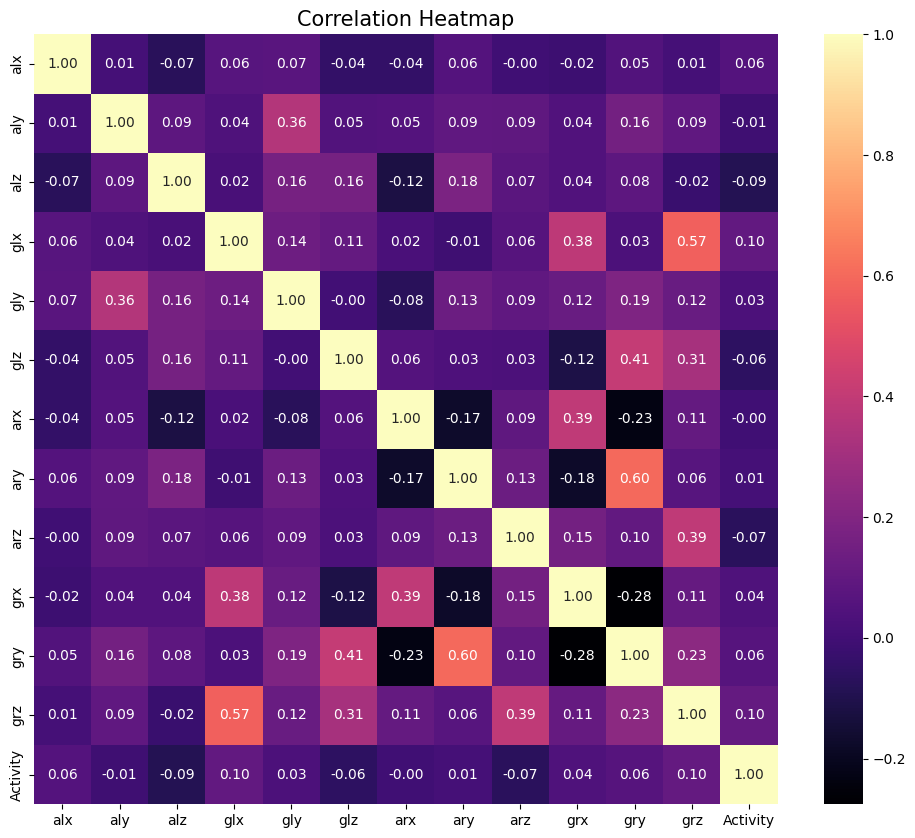

In [ ]:
#Correlation heat map
numerical_features = [
    col for col in mhealth_data.select_dtypes(include=[np.number]).columns
]

#Correlation matrix
correlation_matrix = mhealth_data[numerical_features].corr()

#Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='magma')
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

In [ ]:
#Data shape
X = mhealth_data.drop('Activity', axis=1)
y = mhealth_data['Activity']

print(X.shape, y.shape)

(999999, 13) (999999,)


<Axes: >

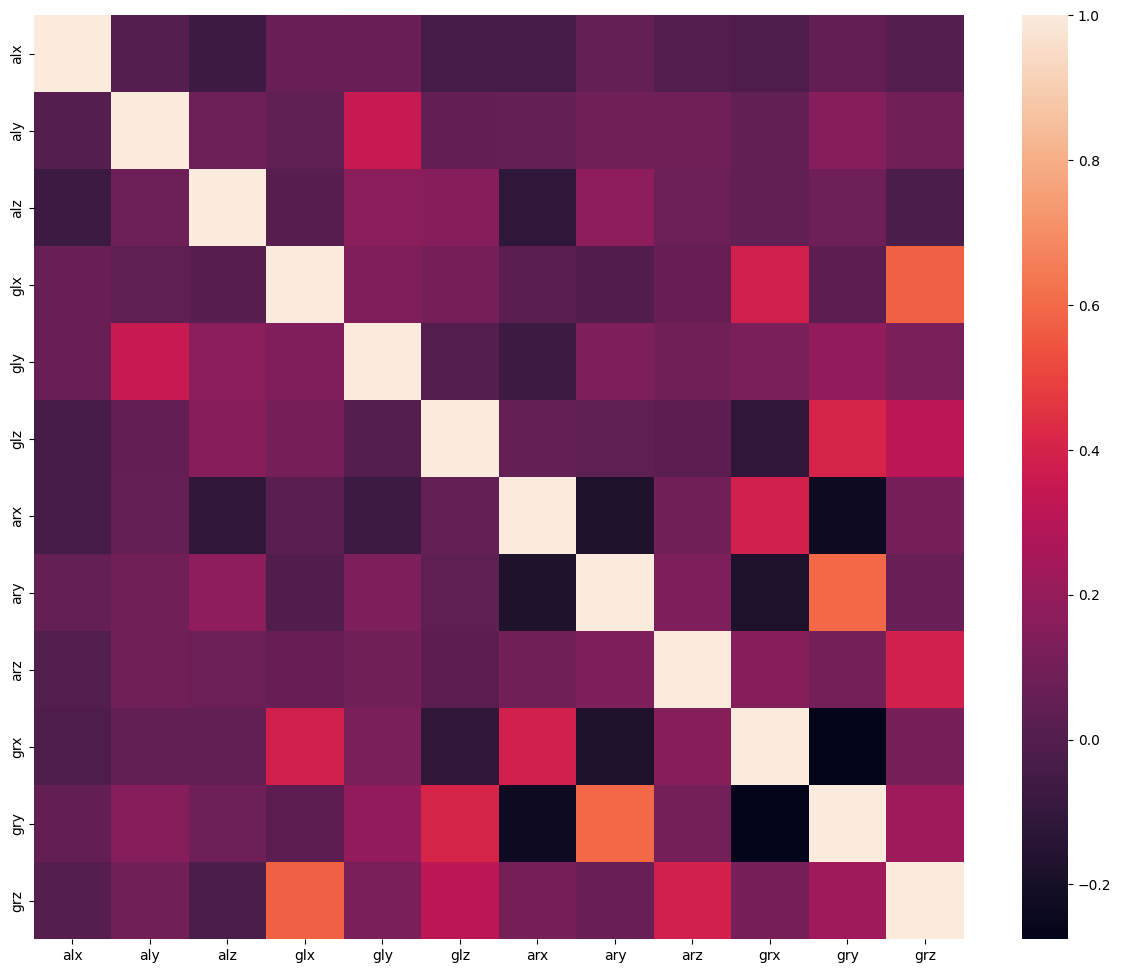

In [ ]:
#Plotting the correlation heatmap
correlation_matrix = X.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix)

In [ ]:
#Check multicollinearity
multicollinear_cols = set()

for i in range (len(correlation_matrix.columns)):
  for j in range(i):
    if abs(correlation_matrix.iloc[i,j]) > 0.7:
      multicollinear_cols.add(correlation_matrix.columns[i])

print(len(multicollinear_cols)) #No features with high collinearity

0


In [ ]:
#Check for low variance
import numpy as np
variances = np.var(mhealth_data, axis=0)

#Set a threshold to identify low variance features
threshold = 0.1

#Find the indices of low variance features
low_variance_indices = np.where(variances < threshold)[0]

#Print the indices of low variance features
print("Low Variance Feature Indices:", low_variance_indices) #No features with low variance

Low Variance Feature Indices: []


#Data Preparation

In [11]:
#Data type
column_types = mhealth_data.dtypes

#Filter string variables
string_columns = column_types[column_types == 'object'].index.tolist()

print("String columns:", string_columns)

String columns: ['subject']


In [12]:
#Encoding the 'subject' column
subject_mapping = {'subject1': 1, 'subject2': 2, 'subject3': 3, 'subject4': 4, 'subject5': 5, 'subject6': 6, 'subject7': 7, 'subject8': 8, 'subject9': 9}
mhealth_data['subject'] = mhealth_data['subject'].map(subject_mapping)

#Verifying the encoding
subject_counts = mhealth_data['subject'].value_counts()
subject_counts

1    161280
2    130561
8    129024
3    122112
5    119808
4    116736
7    104448
6     98304
9     17726
Name: subject, dtype: int64

In [13]:
#Splitting data
#Grouping by 'subject'
grouped = mhealth_data.groupby('subject')
grouped_dfs = [group for _, group in grouped]

#Splitting the groups into training and test sets with an 80:20 ratio
train_groups, test_groups = train_test_split(grouped_dfs, test_size=0.2, random_state=42)

#Reassembling the training and test datasets from the groups
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

#Displaying the shape of the training and test sets
train_df_shape = train_df.shape
test_df_shape = test_df.shape

train_df_shape, test_df_shape

((740414, 14), (259585, 14))

In [14]:
#Scaling data

#Identifying numerical columns
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns.remove('subject')
numerical_columns.remove('Activity')

#Initializing the StandardScaler
scaler = StandardScaler()

#Fitting the scaler to the training data and transforming both training and test data
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

#Checking the first few rows of the normalized training data
train_df.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
650497,-0.552567,0.055747,-0.810059,0.578981,-0.800349,0.501238,-1.814050,0.678081,-0.577362,-0.556227,2.101663,0.012934,0,6
650498,-1.531305,0.104970,-0.369903,0.693642,-0.720535,0.533071,-1.213665,0.758524,-0.989728,-0.556227,2.101663,0.012934,0,6
650499,-1.634742,0.162005,-0.446628,0.693642,-0.720535,0.533071,-0.665509,0.721946,-1.405218,-0.770194,1.968628,-0.202877,0,6
650500,-1.058302,0.102992,-0.337213,0.693642,-0.720535,0.533071,-0.339275,0.722070,-1.640731,-0.770194,1.968628,-0.202877,0,6
650501,-1.119704,0.167596,-0.387926,0.601930,-0.704601,0.653347,-0.163938,0.695687,-1.610853,-0.770194,1.968628,-0.202877,0,6


In [15]:
#Verify
train_df.shape

(740414, 14)

In [16]:
#Checking the class distribution in the 'Activity' column of the training set
subject_counts = train_df['Activity'].value_counts()
subject_counts

0     530225
1      21504
2      19262
3      18432
4      18432
9      18432
10     18432
11     18432
5      18432
6      17665
8      17511
7      17460
12      6195
Name: Activity, dtype: int64

In [17]:
class_distribution = train_df.groupby('subject').apply(lambda x : x.iloc[-1]['Activity']).value_counts()
class_distribution

0.0    6
2.0    1
dtype: int64

In [18]:
#Grouping the original training data by 'subject'
grouped_by_patient = train_df.groupby('subject')

#Creating separate lists for each class
groups_class_0 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 0]
groups_class_1 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 1]
groups_class_2 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 2]
groups_class_3 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 3]
groups_class_4 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 4]
groups_class_5 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 5]
groups_class_6 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 6]
groups_class_7 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 7]
groups_class_8 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 8]
groups_class_9 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 9]
groups_class_10 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 10]
groups_class_11 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 11]
groups_class_12 = [grouped_by_patient.get_group(patient) for patient in grouped_by_patient.groups if grouped_by_patient.get_group(patient)['Activity'].iloc[-1] == 12]


In [19]:
#Combine dataset (no resampling due to time-order of data)
combined_groups = groups_class_0 + groups_class_1 + groups_class_2 + groups_class_3 + groups_class_4 + groups_class_5 + groups_class_6 + groups_class_7 + groups_class_8 + groups_class_9 + groups_class_10 + groups_class_11 + groups_class_12

#Preparing to create a modified copy of the combined dataset
combined_groups_copy = []
i = 0
#Looping over each group in the combined dataset
for i, group in tqdm(enumerate(combined_groups)):
    #Assigning a new, unique identifier to each record in the group
    group.loc[:,'subject'] = i
    #Incrementing the identifier for the next group
    i += 1
    #Appending a copy of the modified group to the combined_groups_copy list
    combined_groups_copy.append(group.copy())

7it [00:00, 151.57it/s]


In [20]:
#Reassembling the combined training dataset
train_df_combined = pd.concat(combined_groups_copy, ignore_index=True)

In [21]:
train_df_combined

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,0.203950,-0.010298,0.245962,0.261780,-0.608852,-1.041064,-1.093245,0.219993,-0.668404,-0.299446,-1.006306,-0.497150,0,0
1,0.255810,0.035775,0.255924,0.223553,-0.603522,-1.033988,-1.088613,0.265791,-0.710112,-0.299446,-1.006306,-0.497150,0,0
2,0.261183,0.021272,0.255407,0.223553,-0.603522,-1.033988,-1.063388,0.273344,-0.646057,-0.299446,-1.006306,-0.497150,0,0
3,0.203055,0.054795,0.230872,0.223553,-0.603522,-1.033988,-1.088696,0.266412,-0.622734,-0.313706,-1.002527,-0.512845,0,0
4,0.263408,0.064854,0.261005,0.223553,-0.603522,-1.033988,-1.103769,0.296625,-0.612630,-0.313706,-1.002527,-0.512845,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740409,-0.161642,0.168085,0.949535,-0.911563,0.226318,1.307769,-0.672250,0.574250,1.058653,-0.752369,1.676680,0.562239,2,6
740410,-0.159710,0.201608,0.925435,-0.911563,0.226318,1.307769,-0.633130,0.577229,0.979462,-0.752369,1.676680,0.562239,2,6
740411,-0.159638,0.167499,0.904580,-0.949776,0.236978,1.332526,-0.715753,0.580740,0.974432,-0.780906,1.654508,0.534767,2,6
740412,-0.149440,0.186812,0.901504,-0.949776,0.236978,1.332526,-0.677233,0.584499,1.003801,-0.780906,1.654508,0.534767,2,6


#Sequence Generation

In [22]:
pip install deprecation

In [23]:
columns = ['alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'arx', 'ary', 'arz', 'grx', 'gry', 'grz']

In [24]:
def create_sequences(mhealth_data, sequence_length=100):
    sequences = []
    output = []
    for i in range(0, len(mhealth_data) - sequence_length + 1, sequence_length):
        sequence = mhealth_data[i:i + sequence_length]
        label = sequence['Activity'].iloc[0]
        sequences.append(sequence[columns].values)
        output.append(label)

    return np.array(sequences), np.array(output)

#Creating sequences for training and test data
X_train, y_train = create_sequences(train_df_combined, sequence_length=100)
X_test, y_test = create_sequences(test_df, sequence_length=100)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7404, 100, 12), (7404,), (2595, 100, 12), (2595,))

#RNN

##15 Epochs

In [25]:
#Attempt with 15 epochs
#Hyperparameters
input_size = X_train.shape[2]
hidden_size = 256
num_classes = 13
epochs = 15
learning_rate = 0.001
batch_size = 512
landa = 0.001

#Data preparation
train_dataset = TensorDataset(t.tensor(X_train, dtype=t.float32), t.tensor(y_train, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(X_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#RNN layers and additional fully connected layer
rnn_layer1 = nn.RNN(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)
rnn_layer2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
fc_layer1 = nn.Linear(hidden_size, hidden_size // 2)
fc_layer2 = nn.Linear(hidden_size  // 2, num_classes)

#Dropout layer
dropout_fc = nn.Dropout(0.2)

#Activation function
relu = nn.ReLU()

#Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

#Lists to store accuracies and losses
all_loss = []
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

#Training loop
for epoch in range(epochs):

    if epoch % 10 == 0:
        learning_rate *= 0.9

    optimizer = Adam(list(rnn_layer1.parameters())+ list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        #Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)
        out, _ = rnn_layer2(out)
        out = out[:, -1, :]
        out = relu(fc_layer1(out))
        out = dropout_fc(out)
        out = fc_layer2(out)

        #Regularization
        l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        loss = loss_fn(out, Y) + landa * l2_term
        per_epoch_loss_list.append(loss.item())

        #Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # max_iter -=1
        # if max_iter == 0:
        #     break
    all_loss += per_epoch_loss_list

    #Evaluation on training and validation data
    rnn_layer1.eval()
    rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        #Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        #Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        #Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        #Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    #Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    #Set the model back to train mode
    rnn_layer1.train()
    rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

Epoch 0/15 ---> Train Accuracy: 71.63695299837926%, Validation Accuracy: 73.44894026974951%
Epoch 1/15 ---> Train Accuracy: 72.59589411129119%, Validation Accuracy: 73.60308285163777%
Epoch 2/15 ---> Train Accuracy: 71.52890329551593%, Validation Accuracy: 73.02504816955684%
Epoch 3/15 ---> Train Accuracy: 70.19178822258239%, Validation Accuracy: 72.98651252408477%
Epoch 4/15 ---> Train Accuracy: 72.6904376012966%, Validation Accuracy: 73.68015414258188%
Epoch 5/15 ---> Train Accuracy: 72.5148568341437%, Validation Accuracy: 74.18111753371869%
Epoch 6/15 ---> Train Accuracy: 72.10967044840626%, Validation Accuracy: 73.41040462427746%
Epoch 7/15 ---> Train Accuracy: 73.01458670988654%, Validation Accuracy: 73.33333333333333%
Epoch 8/15 ---> Train Accuracy: 72.55537547271744%, Validation Accuracy: 73.64161849710983%
Epoch 9/15 ---> Train Accuracy: 72.86601836844949%, Validation Accuracy: 73.98843930635839%
Epoch 10/15 ---> Train Accuracy: 73.257698541329%, Validation Accuracy: 72.7938342

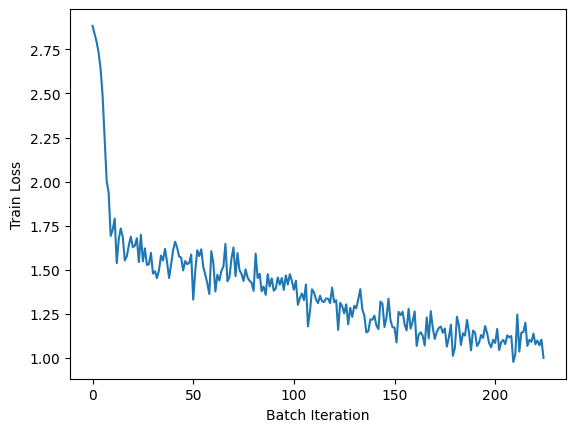

In [26]:
#Plot batch iteration (15 epochs)
plt.plot([i for i in range(len(all_loss))], all_loss, label="Train")
plt.xlabel('Batch Iteration')
plt.ylabel('Train Loss')
plt.show()

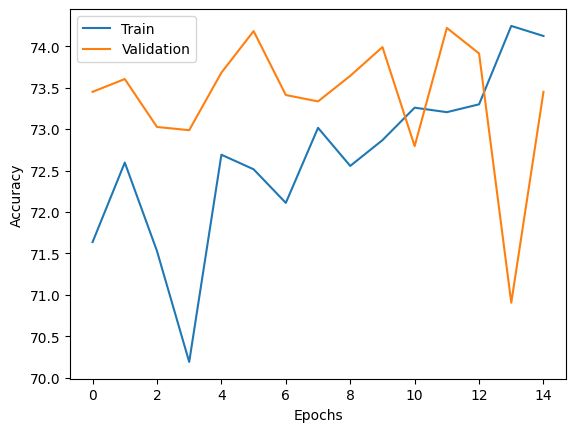

In [27]:
# Plot training and validation accuracy over 15 epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

##20 Epochs

In [28]:
#Attempt with 20 epochs
#Hyperparameters
input_size = X_train.shape[2]
hidden_size = 256
num_classes = 13
epochs = 20
learning_rate = 0.001
batch_size = 512
landa = 0.001

#Data preparation
train_dataset = TensorDataset(t.tensor(X_train, dtype=t.float32), t.tensor(y_train, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(X_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#RNN layers and additional fully connected layer
rnn_layer1 = nn.RNN(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)
rnn_layer2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
fc_layer1 = nn.Linear(hidden_size, hidden_size // 2)
fc_layer2 = nn.Linear(hidden_size  // 2, num_classes)

#Dropout layer
dropout_fc = nn.Dropout(0.2)

#Activation function
relu = nn.ReLU()

#Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

#Lists to store accuracies and losses
all_loss = []
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

#Training loop
for epoch in range(epochs):

    if epoch % 10 == 0:
        learning_rate *= 0.9

    optimizer = Adam(list(rnn_layer1.parameters())+ list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        #Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)
        out, _ = rnn_layer2(out)
        out = out[:, -1, :]
        out = relu(fc_layer1(out))
        out = dropout_fc(out)
        out = fc_layer2(out)

        #Regularization
        l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        loss = loss_fn(out, Y) + landa * l2_term
        per_epoch_loss_list.append(loss.item())

        #Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # max_iter -=1
        # if max_iter == 0:
        #     break
    all_loss += per_epoch_loss_list

    #Evaluation on training and validation data
    rnn_layer1.eval()
    rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        #Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        #Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        #Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        #Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    #Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    #Set the model back to train mode
    rnn_layer1.train()
    rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

Epoch 0/20 ---> Train Accuracy: 71.63695299837926%, Validation Accuracy: 73.44894026974951%
Epoch 1/20 ---> Train Accuracy: 72.75796866558618%, Validation Accuracy: 73.75722543352602%
Epoch 2/20 ---> Train Accuracy: 67.20691518098326%, Validation Accuracy: 67.4373795761079%
Epoch 3/20 ---> Train Accuracy: 70.78606158833063%, Validation Accuracy: 69.01734104046243%
Epoch 4/20 ---> Train Accuracy: 71.66396542409508%, Validation Accuracy: 73.44894026974951%
Epoch 5/20 ---> Train Accuracy: 71.27228525121556%, Validation Accuracy: 73.14065510597302%
Epoch 6/20 ---> Train Accuracy: 71.63695299837926%, Validation Accuracy: 73.44894026974951%
Epoch 7/20 ---> Train Accuracy: 71.63695299837926%, Validation Accuracy: 73.44894026974951%
Epoch 8/20 ---> Train Accuracy: 72.2312263641275%, Validation Accuracy: 73.17919075144509%
Epoch 9/20 ---> Train Accuracy: 72.77147487844408%, Validation Accuracy: 73.3718689788054%
Epoch 10/20 ---> Train Accuracy: 72.55537547271744%, Validation Accuracy: 73.603082

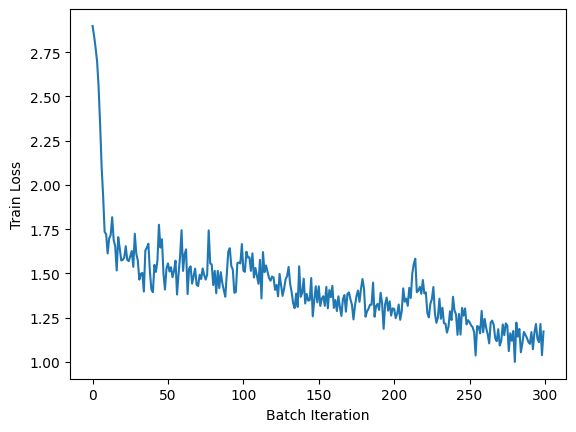

In [29]:
#Plot batch iteration (20 epochs)
plt.plot([i for i in range(len(all_loss))], all_loss, label="Train")
plt.xlabel('Batch Iteration')
plt.ylabel('Train Loss')
plt.show()

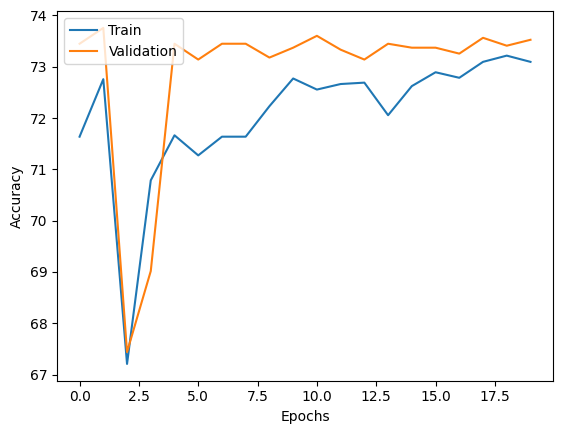

In [30]:
# Plot training and validation accuracy over 20 epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

##30 Epochs

In [ ]:
#Attempt with 30 epochs
#Hyperparameters
input_size = X_train.shape[2]
hidden_size = 256
num_classes = 13
epochs = 30
learning_rate = 0.001
batch_size = 512
landa = 0.001

#Data preparation
train_dataset = TensorDataset(t.tensor(X_train, dtype=t.float32), t.tensor(y_train, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(X_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#RNN layers and additional fully connected layer
rnn_layer1 = nn.RNN(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)
rnn_layer2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
fc_layer1 = nn.Linear(hidden_size, hidden_size // 2)
fc_layer2 = nn.Linear(hidden_size  // 2, num_classes)

#Dropout layer
dropout_fc = nn.Dropout(0.2)

#Activation function
relu = nn.ReLU()

#Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

#Lists to store accuracies and losses
all_loss = []
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

#Training loop
for epoch in range(epochs):

    if epoch % 10 == 0:
        learning_rate *= 0.9

    optimizer = Adam(list(rnn_layer1.parameters())+ list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        #Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)
        out, _ = rnn_layer2(out)
        out = out[:, -1, :]
        out = relu(fc_layer1(out))
        out = dropout_fc(out)
        out = fc_layer2(out)

        #Regularization
        l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        loss = loss_fn(out, Y) + landa * l2_term
        per_epoch_loss_list.append(loss.item())

        #Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # max_iter -=1
        # if max_iter == 0:
        #     break
    all_loss += per_epoch_loss_list

    #Evaluation on training and validation data
    rnn_layer1.eval()
    rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        #Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        #Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        #Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        #Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    #Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    #Set the model back to train mode
    rnn_layer1.train()
    rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

Epoch 0/30 ---> Train Accuracy: 71.63695299837926%, Validation Accuracy: 73.44894026974951%
Epoch 1/30 ---> Train Accuracy: 72.74446245272826%, Validation Accuracy: 73.71868978805395%
Epoch 2/30 ---> Train Accuracy: 66.93679092382496%, Validation Accuracy: 64.16184971098266%
Epoch 3/30 ---> Train Accuracy: 70.08373851971908%, Validation Accuracy: 68.67052023121387%
Epoch 4/30 ---> Train Accuracy: 71.66396542409508%, Validation Accuracy: 73.44894026974951%
Epoch 5/30 ---> Train Accuracy: 71.83954619124798%, Validation Accuracy: 73.41040462427746%
Epoch 6/30 ---> Train Accuracy: 71.98811453268503%, Validation Accuracy: 73.33333333333333%
Epoch 7/30 ---> Train Accuracy: 72.71745002701243%, Validation Accuracy: 73.14065510597302%
Epoch 8/30 ---> Train Accuracy: 72.6904376012966%, Validation Accuracy: 73.71868978805395%
Epoch 9/30 ---> Train Accuracy: 72.47433819556996%, Validation Accuracy: 73.48747591522158%
Epoch 10/30 ---> Train Accuracy: 72.93354943273906%, Validation Accuracy: 73.6416

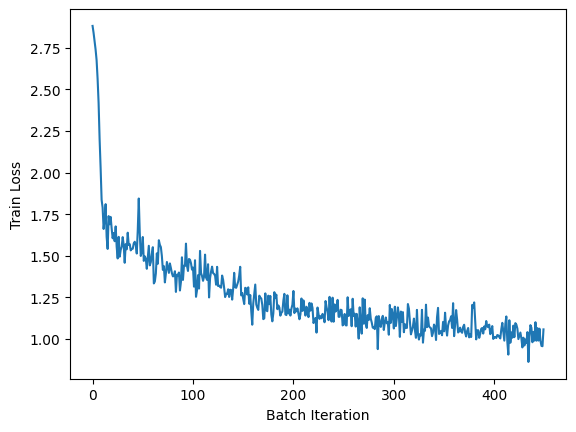

In [ ]:
#Plot batch iteration (30 epochs)
plt.plot([i for i in range(len(all_loss))], all_loss, label="Train")
plt.xlabel('Batch Iteration')
plt.ylabel('Train Loss')
plt.show()

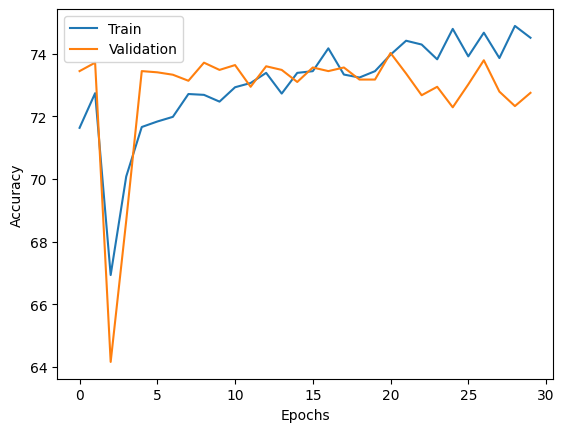

In [ ]:
#Plot training and validation accuracy over 30 epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

##50 Epochs

In [ ]:
#Attempt with 50 epochs
#Hyperparameters
input_size = X_train.shape[2]
hidden_size = 256
num_classes = 13
epochs = 50
learning_rate = 0.0001
batch_size = 512
landa = 0.001

#Data preparation
train_dataset = TensorDataset(t.tensor(X_train, dtype=t.float32), t.tensor(y_train, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(X_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#RNN layers and additional fully connected layer
rnn_layer1 = nn.RNN(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)
rnn_layer2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
fc_layer1 = nn.Linear(hidden_size, hidden_size // 2)
fc_layer2 = nn.Linear(hidden_size  // 2, num_classes)

#Dropout layer
dropout_fc = nn.Dropout(0.2)

#Activation function
relu = nn.ReLU()

#Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

#Lists to store accuracies and losses
all_loss = []
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

#Training loop
for epoch in range(epochs):

    if epoch % 10 == 0:
        learning_rate *= 0.9

    optimizer = Adam(list(rnn_layer1.parameters())+ list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        #Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)
        out, _ = rnn_layer2(out)
        out = out[:, -1, :]
        out = relu(fc_layer1(out))
        out = dropout_fc(out)
        out = fc_layer2(out)

        #Regularization
        l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        loss = loss_fn(out, Y) + landa * l2_term
        per_epoch_loss_list.append(loss.item())

        #Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # max_iter -=1
        # if max_iter == 0:
        #     break
    all_loss += per_epoch_loss_list

    #Evaluation on training and validation data
    rnn_layer1.eval()
    rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        #Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        #Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        #Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        #Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    #Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    #Set the model back to train mode
    rnn_layer1.train()
    rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

Epoch 0/50 ---> Train Accuracy: 60.38627768773636%, Validation Accuracy: 63.50674373795761%
Epoch 1/50 ---> Train Accuracy: 72.08265802269044%, Validation Accuracy: 73.25626204238921%
Epoch 2/50 ---> Train Accuracy: 71.62344678552134%, Validation Accuracy: 73.41040462427746%
Epoch 3/50 ---> Train Accuracy: 71.62344678552134%, Validation Accuracy: 73.41040462427746%
Epoch 4/50 ---> Train Accuracy: 71.60994057266342%, Validation Accuracy: 73.41040462427746%
Epoch 5/50 ---> Train Accuracy: 71.42085359265262%, Validation Accuracy: 73.33333333333333%
Epoch 6/50 ---> Train Accuracy: 71.38033495407888%, Validation Accuracy: 73.02504816955684%
Epoch 7/50 ---> Train Accuracy: 72.36628849270664%, Validation Accuracy: 73.5645472061657%
Epoch 8/50 ---> Train Accuracy: 71.97460831982713%, Validation Accuracy: 73.64161849710983%
Epoch 9/50 ---> Train Accuracy: 71.51539708265803%, Validation Accuracy: 73.29479768786128%
Epoch 10/50 ---> Train Accuracy: 71.71799027552674%, Validation Accuracy: 73.3718

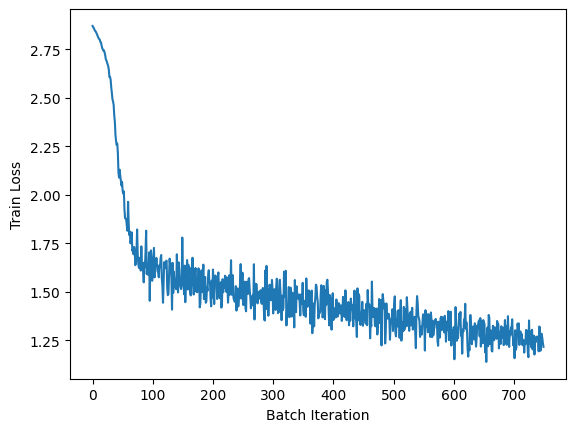

In [ ]:
#Plot batch iteration (50 epochs)
plt.plot([i for i in range(len(all_loss))], all_loss, label="Train")
plt.xlabel('Batch Iteration')
plt.ylabel('Train Loss')
plt.show()

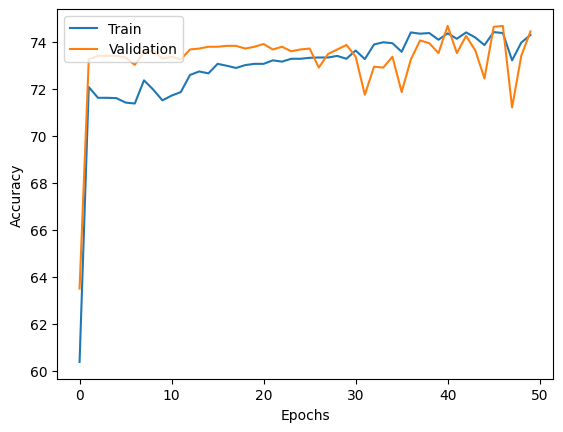

In [ ]:
# Plot training and validation accuracy over 50 epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()